In [1]:
#Loading the libraries
import os
import sagemaker
from sagemaker import get_execution_role
import boto3
import pandas as pd
from sagemaker.tensorflow import TensorFlow
import tensorflow as tf

import numpy as np
import pandas as pd

import pathlib
import shutil
import tempfile

from  IPython import display
from matplotlib import pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE
import re

#important libraries for preprocessing using NLTK
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from collections import Counter

!pip install tweet-preprocessor
import preprocessor as p

#I dont think we need this
!python -m pip install -U gensim
from gensim.parsing.preprocessing import remove_stopwords

#We dont need this library for now
#installing ekphrasis
!pip install ekphrasis

# Segmenter used for sengmenting the hashtags
from ekphrasis.classes.segmenter import Segmenter
#segmenter using the word statistics from Twitter
seg = Segmenter(corpus="twitter")

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.
Requirement already up-to-date: gensim in /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages (3.8.3)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.
Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [2]:
#To Preprocess using the functions from tweet-processor package
def preprocess_tweet(row):
    text = row['Tweet']
    text = p.clean(text)
    return text

In [3]:
#remove_punctuation to remove punctuation from words

def remove_punctuation(words):
    new_words_list = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', (word))
        if new_word!= '':
            new_words_list.append(new_word)
            return new_words_list

In [4]:
#Using WordNet Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
word_tokenizer = TweetTokenizer()
#Lemmatize_text function lemmatizes the words
def lemmatize_text(text):
     return [(lemmatizer.lemmatize(w)) for w in \
                                     word_tokenizer.tokenize((text))]

In [5]:
#Convert list to string function
def convert_list_to_string(original_list, separator=' '):
    return separator.join(original_list)

In [138]:
#Loading the file
pd.set_option('max_colwidth',150)
filename = "train.csv"
tweets_df = pd.read_csv(filename,index_col=None, header=0, engine='python')

In [7]:
#Checking the contents of the datafile
tweets_df.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos
5,Hillary can not win. Here's hoping the Dems of...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
6,Respect FOR the law and respect BY the law Yes...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,pos
7,I don't want to be appointed to an Ambassador ...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg
8,#StopHillary2016 @HillaryClinton if there was ...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
9,@HillaryClinton End lawless #ClintonFoundation...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg


In [8]:
#Checking the tweet text content
print(tweets_df['Tweet'][0])


@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot


In [9]:
#Checking the values in Target Column
tweets_df['Target'].value_counts()

Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: Target, dtype: int64

In [10]:
#Checking the values in Sentiment Column
tweets_df['Sentiment'].value_counts()

neg      1762
pos       963
other     189
Name: Sentiment, dtype: int64

In [11]:
#Checking the values in Stance Column
tweets_df['Stance'].value_counts()

AGAINST    1395
NONE        766
FAVOR       753
Name: Stance, dtype: int64

In [12]:
#Hastag Preprocessing
tweets_df["hashtag"] = tweets_df["Tweet"].apply(lambda x: re.findall(r"#(\w+)", x))
tweets_df['hashtag'].head(10)

0                  [HandOverTheServer, Benghazi, tcot]
1                                               [Ohio]
2                                                   []
3                           [WhyImNotVotingForHillary]
4                                                   []
5                                         [Warren2016]
6                                     [BaltimoreRiots]
7                                                   []
8                                    [StopHillary2016]
9    [ClintonFoundation, Benghazi, Arrest, BillClin...
Name: hashtag, dtype: object

In [13]:
#Converting the hashtags from list to string
tweets_df['hashtag_string'] = tweets_df['hashtag'].apply(convert_list_to_string)
tweets_df.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment,hashtag,hashtag_string
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[HandOverTheServer, Benghazi, tcot]",HandOverTheServer Benghazi tcot
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,[Ohio],Ohio
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[],
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[WhyImNotVotingForHillary],WhyImNotVotingForHillary
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,[],


In [14]:
#Segmenting the hashtags
for i in range(tweets_df.shape[0]):
    tweets_df["hashtag_string"][i] = seg.segment(tweets_df["hashtag_string"][i])
tweets_df.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment,hashtag,hashtag_string
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,[Ohio],ohio
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[],
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[WhyImNotVotingForHillary],why im not voting for hillary
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,[],


In [15]:
#Appending Hashtags to the Tweet Text
#Hastag Segmenting
for i in range(tweets_df.shape[0]):
    tweets_df["Tweet"][i] = tweets_df["Tweet"][i] + " " + tweets_df["hashtag_string"][i]
tweets_df["Tweet"][0]

'@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot hand over the server  benghazi tcot'

In [16]:
#Checking the tweet_df dataframe after hashtag processing
tweets_df.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment,hashtag,hashtag_string
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,[Ohio],ohio
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[],
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[WhyImNotVotingForHillary],why im not voting for hillary
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,[],
5,Hillary can not win. Here's hoping the Dems of...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[Warren2016],warren 2016
6,Respect FOR the law and respect BY the law Yes...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,pos,[BaltimoreRiots],baltimore riots
7,I don't want to be appointed to an Ambassador ...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg,[],
8,#StopHillary2016 @HillaryClinton if there was ...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[StopHillary2016],stop hillary 2016
9,@HillaryClinton End lawless #ClintonFoundation...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[ClintonFoundation, Benghazi, Arrest, BillClin...",clinton foundation benghazi arrest bill cli...


In [17]:
#Mention Processing
tweets_df["mention"] = tweets_df["Tweet"].apply(lambda x: re.findall(r"@(\w+)", x))
tweets_df['mention'].head(10)

0           [tedcruz]
1                  []
2           [TheView]
3                  []
4    [PortiaABoulger]
5                  []
6                  []
7                  []
8    [HillaryClinton]
9    [HillaryClinton]
Name: mention, dtype: object

In [18]:
#Checking the tweet_df dataframe after mention processing
tweets_df.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment,hashtag,hashtag_string,mention
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot,[tedcruz]
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,[Ohio],ohio,[]
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[],,[TheView]
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[WhyImNotVotingForHillary],why im not voting for hillary,[]
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,[],,[PortiaABoulger]
5,Hillary can not win. Here's hoping the Dems of...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[Warren2016],warren 2016,[]
6,Respect FOR the law and respect BY the law Yes...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,pos,[BaltimoreRiots],baltimore riots,[]
7,I don't want to be appointed to an Ambassador ...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg,[],,[]
8,#StopHillary2016 @HillaryClinton if there was ...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[StopHillary2016],stop hillary 2016,[HillaryClinton]
9,@HillaryClinton End lawless #ClintonFoundation...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[ClintonFoundation, Benghazi, Arrest, BillClin...",clinton foundation benghazi arrest bill cli...,[HillaryClinton]


In [19]:
#Clean the mentions and hashtags,urls and mentions from the tweet text using preprocess function 
# from tweet-preprocessor
tweets_df['Tweet'] = tweets_df.apply(preprocess_tweet, axis=1)
tweets_df.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment,hashtag,hashtag_string,mention
0,"And, she wiped clean + k deleted emails, expla...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot,[tedcruz]
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,[Ohio],ohio,[]
2,I think our country is ready for a female pres...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[],,[TheView]
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[WhyImNotVotingForHillary],why im not voting for hillary,[]
4,Thank you for adding me to your list,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,[],,[PortiaABoulger]
5,Hillary can not win. Here's hoping the Dems of...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[Warren2016],warren 2016,[]
6,Respect FOR the law and respect BY the law Yes...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,pos,[BaltimoreRiots],baltimore riots,[]
7,I don't want to be appointed to an Ambassador ...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg,[],,[]
8,if there was a woman with integrity and honest...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[StopHillary2016],stop hillary 2016,[HillaryClinton]
9,End lawless . Jail Butcher of . rapist . clint...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[ClintonFoundation, Benghazi, Arrest, BillClin...",clinton foundation benghazi arrest bill cli...,[HillaryClinton]


In [20]:
#Checking the contents of the dataframe
tweets_df.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment,hashtag,hashtag_string,mention
0,"And, she wiped clean + k deleted emails, expla...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot,[tedcruz]
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,[Ohio],ohio,[]
2,I think our country is ready for a female pres...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[],,[TheView]
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[WhyImNotVotingForHillary],why im not voting for hillary,[]
4,Thank you for adding me to your list,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,[],,[PortiaABoulger]
5,Hillary can not win. Here's hoping the Dems of...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[Warren2016],warren 2016,[]
6,Respect FOR the law and respect BY the law Yes...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,pos,[BaltimoreRiots],baltimore riots,[]
7,I don't want to be appointed to an Ambassador ...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg,[],,[]
8,if there was a woman with integrity and honest...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[StopHillary2016],stop hillary 2016,[HillaryClinton]
9,End lawless . Jail Butcher of . rapist . clint...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[ClintonFoundation, Benghazi, Arrest, BillClin...",clinton foundation benghazi arrest bill cli...,[HillaryClinton]


In [21]:
#Convert the text to lower text
tweets_df['Tweet'] = tweets_df['Tweet'].str.lower().str.replace('[^\w\s]','').str.replace('\s\s+', '')
tweets_df.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment,hashtag,hashtag_string,mention
0,"and, she wiped clean + k deleted emails, expla...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot,[tedcruz]
1,hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,[Ohio],ohio,[]
2,i think our country is ready for a female pres...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[],,[TheView]
3,i just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[WhyImNotVotingForHillary],why im not voting for hillary,[]
4,thank you for adding me to your list,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,[],,[PortiaABoulger]
5,hillary can not win. here's hoping the dems of...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[Warren2016],warren 2016,[]
6,respect for the law and respect by the law yes...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,pos,[BaltimoreRiots],baltimore riots,[]
7,i don't want to be appointed to an ambassador ...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg,[],,[]
8,if there was a woman with integrity and honest...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[StopHillary2016],stop hillary 2016,[HillaryClinton]
9,end lawless . jail butcher of . rapist . clint...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[ClintonFoundation, Benghazi, Arrest, BillClin...",clinton foundation benghazi arrest bill cli...,[HillaryClinton]


In [22]:
#Remove Digits from the Tweet
tweets_df['Tweet'] = tweets_df['Tweet'].str.replace('\d+', '')
tweets_df.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment,hashtag,hashtag_string,mention
0,"and, she wiped clean + k deleted emails, expla...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot,[tedcruz]
1,hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,[Ohio],ohio,[]
2,i think our country is ready for a female pres...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[],,[TheView]
3,i just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[WhyImNotVotingForHillary],why im not voting for hillary,[]
4,thank you for adding me to your list,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,[],,[PortiaABoulger]
5,hillary can not win. here's hoping the dems of...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[Warren2016],warren 2016,[]
6,respect for the law and respect by the law yes...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,pos,[BaltimoreRiots],baltimore riots,[]
7,i don't want to be appointed to an ambassador ...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg,[],,[]
8,if there was a woman with integrity and honest...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[StopHillary2016],stop hillary 2016,[HillaryClinton]
9,end lawless . jail butcher of . rapist . clint...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[ClintonFoundation, Benghazi, Arrest, BillClin...",clinton foundation benghazi arrest bill cli...,[HillaryClinton]


In [23]:
#Lemmatize and tokenize text
tweets_df['Tweet'] = tweets_df['Tweet'].apply(lemmatize_text)
tweets_df.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment,hashtag,hashtag_string,mention
0,"[and, ,, she, wiped, clean, +, k, deleted, ema...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot,[tedcruz]
1,"[hillary, is, our, best, choice, if, we, truly...",Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,[Ohio],ohio,[]
2,"[i, think, our, country, is, ready, for, a, fe...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[],,[TheView]
3,"[i, just, gave, an, unhealthy, amount, of, my,...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[WhyImNotVotingForHillary],why im not voting for hillary,[]
4,"[thank, you, for, adding, me, to, your, list]",Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,[],,[PortiaABoulger]
5,"[hillary, can, not, win, ., here's, hoping, th...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[Warren2016],warren 2016,[]
6,"[respect, for, the, law, and, respect, by, the...",Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,pos,[BaltimoreRiots],baltimore riots,[]
7,"[i, don't, want, to, be, appointed, to, an, am...",Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg,[],,[]
8,"[if, there, wa, a, woman, with, integrity, and...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[StopHillary2016],stop hillary 2016,[HillaryClinton]
9,"[end, lawless, ., jail, butcher, of, ., rapist...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[ClintonFoundation, Benghazi, Arrest, BillClin...",clinton foundation benghazi arrest bill cli...,[HillaryClinton]


In [24]:
#Remove puntuation from the lemmatize texts
tweets_df['Tweet'] = tweets_df['Tweet'].apply(remove_punctuation)
tweets_df.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment,hashtag,hashtag_string,mention
0,"[and, she, wiped, clean, k, deleted, email, ex...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot,[tedcruz]
1,"[hillary, is, our, best, choice, if, we, truly...",Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,[Ohio],ohio,[]
2,"[i, think, our, country, is, ready, for, a, fe...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[],,[TheView]
3,"[i, just, gave, an, unhealthy, amount, of, my,...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[WhyImNotVotingForHillary],why im not voting for hillary,[]
4,"[thank, you, for, adding, me, to, your, list]",Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,[],,[PortiaABoulger]
5,"[hillary, can, not, win, heres, hoping, the, d...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[Warren2016],warren 2016,[]
6,"[respect, for, the, law, and, respect, by, the...",Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,pos,[BaltimoreRiots],baltimore riots,[]
7,"[i, dont, want, to, be, appointed, to, an, amb...",Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg,[],,[]
8,"[if, there, wa, a, woman, with, integrity, and...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[StopHillary2016],stop hillary 2016,[HillaryClinton]
9,"[end, lawless, jail, butcher, of, rapist, clin...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[ClintonFoundation, Benghazi, Arrest, BillClin...",clinton foundation benghazi arrest bill cli...,[HillaryClinton]


In [25]:
#Last step is to remove the stop words from the lemmatized and tokenized words lists
stop_words = set(stopwords.words('english'))
tweets_df['Tweet'] = tweets_df['Tweet'].apply(lambda x: [item for item in \
                                                         x if item not in stop_words])

In [26]:
#Checking the contents of the dataframe
tweets_df.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment,hashtag,hashtag_string,mention
0,"[wiped, clean, k, deleted, email, explains, de...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot,[tedcruz]
1,"[hillary, best, choice, truly, want, continue,...",Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,[Ohio],ohio,[]
2,"[think, country, ready, female, pres, cant, ev...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[],,[TheView]
3,"[gave, unhealthy, amount, hardearned, money, a...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[WhyImNotVotingForHillary],why im not voting for hillary,[]
4,"[thank, adding, list]",Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,[],,[PortiaABoulger]


In [27]:

tweets_df['Target'].unique()

array(['Hillary Clinton', 'Legalization of Abortion', 'Atheism',
       'Climate Change is a Real Concern', 'Feminist Movement'],
      dtype=object)

In [28]:
!pip install wordcloud

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.



 Generating Word Cloud for Hillary Clinton 



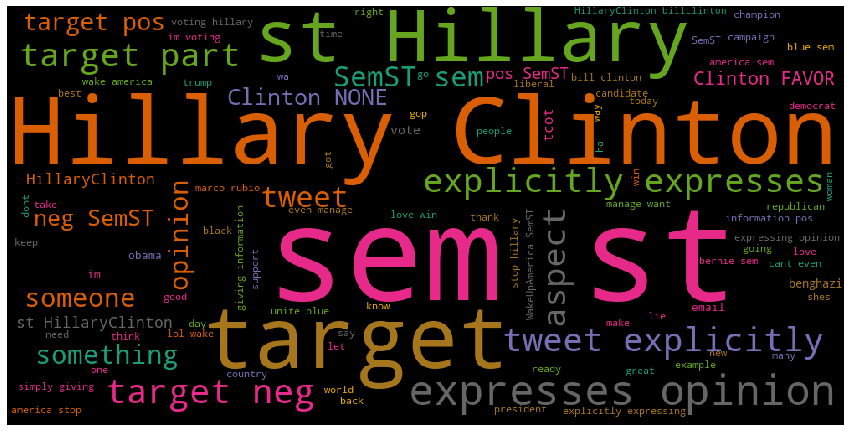


 Generating Word Cloud for Legalization of Abortion 



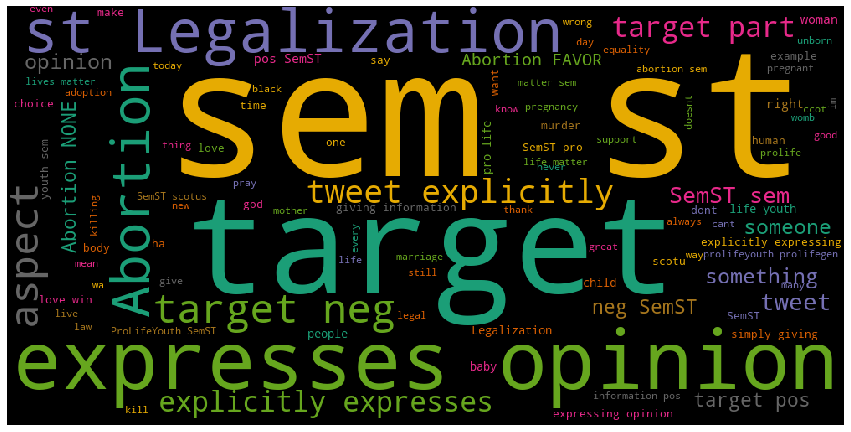


 Generating Word Cloud for Atheism 



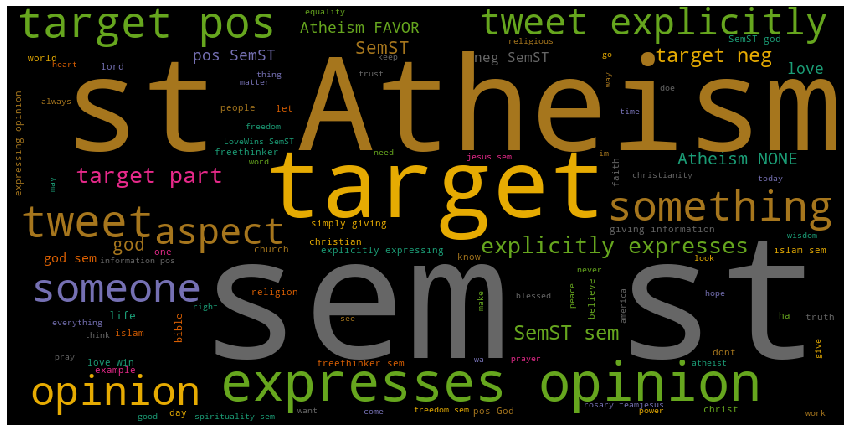


 Generating Word Cloud for Climate Change is a Real Concern 



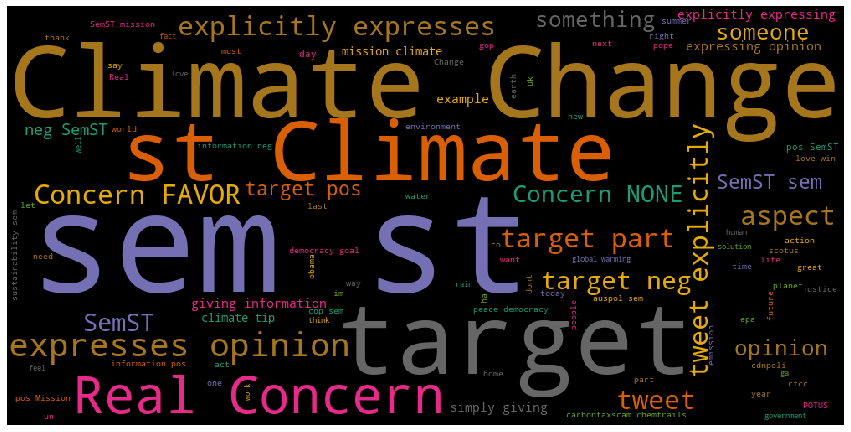


 Generating Word Cloud for Feminist Movement 



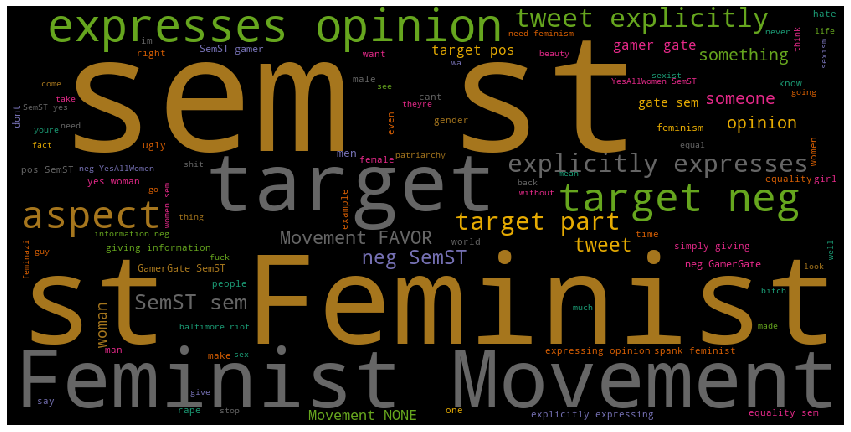

In [29]:
#For loop for generating word cloud for each target variable
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

target_list = ['Hillary Clinton', 'Legalization of Abortion', 'Atheism',
       'Climate Change is a Real Concern', 'Feminist Movement']



for target in target_list:
    wordcloud = WordCloud(width = 1000, height = 500,max_words=100, colormap="Dark2")
    print("\n Generating Word Cloud for {} \n".format(target))
    wordcloud.generate(tweets_df[tweets_df.iloc[:,1] == target].to_string())
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

In [30]:
#Converting the strings to tweets
tweets_df['Tweet'] = tweets_df['Tweet'].apply(convert_list_to_string)
tweets_df.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment,hashtag,hashtag_string,mention
0,wiped clean k deleted email explains derelicti...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot,[tedcruz]
1,hillary best choice truly want continue progre...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,[Ohio],ohio,[]
2,think country ready female pres cant ever hillary,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[],,[TheView]
3,gave unhealthy amount hardearned money away bi...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[WhyImNotVotingForHillary],why im not voting for hillary,[]
4,thank adding list,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,[],,[PortiaABoulger]
5,hillary win heres hoping dems offer real candi...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[Warren2016],warren 2016,[]
6,respect law respect law yes needed desperately...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,pos,[BaltimoreRiots],baltimore riots,[]
7,dont want appointed ambassador post,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg,[],,[]
8,wa woman integrity honesty would vote woman pr...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,[StopHillary2016],stop hillary 2016,[HillaryClinton]
9,end lawless jail butcher rapist clinton founda...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,"[ClintonFoundation, Benghazi, Arrest, BillClin...",clinton foundation benghazi arrest bill cli...,[HillaryClinton]


In [140]:
#Converting the texts and stance to numpy array
texts = np.array(tweets_df['Tweet'][:2914])
stance_labels = np.array(tweets_df['Stance'][:2914])

In [141]:
#Checking the Shape of the text and stance labels
print("Shape of Text: "+str(texts.shape))
print("Shape of Stance Labels: "+str(stance_labels.shape))

Shape of Text: (2914,)
Shape of Stance Labels: (2914,)


In [142]:
#Checking the counter labels
Counter(stance_labels)

Counter({'AGAINST': 1395, 'FAVOR': 753, 'NONE': 766})

In [143]:
stance_labels

array(['AGAINST', 'FAVOR', 'AGAINST', ..., 'AGAINST', 'AGAINST',
       'AGAINST'], dtype=object)

In [144]:
from keras.utils.np_utils import to_categorical #Experimenting

In [145]:
#Checking contents of the text
print(texts)

['@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot'
 'Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio'
 "@TheView I think our country is ready for a female pres, it can't ever be Hillary"
 ...
 "How dare you say my sexual preference is a choice, how dare you say dismembering my preborn isn't. #liberalism #SemST"
 "Equal rights for those 'born that way', no rights for those not yet born. #LiberalLogic #liberalism #life #SemST"
 '#POTUS seals his legacy w/ 1/2 doz wins. The #GOP agenda? STILL!! Repeal #Gun laws & #Obamacare Ban Access 2 #TotalLosers #NoIdeas #SemST']


In [103]:
#Tokenizing the words for 
from keras.preprocessing.text import Tokenizer
MAX_WORDS = 20000
# SOME MACROS That we need to tune later
MAX_SEQ_LENGTH = 200
MAX_WORDS = 20000
EMBEDDING_DIMENSION = 100



#The all the texts
all_text = []
for i in range(texts.shape[0]):
    all_text.append(texts[i])
#print(all_text)

In [147]:
#Truncating the words based on the maximum number of words allowed
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(all_text)
#Integer Encoding 
sequences = tokenizer.texts_to_sequences(all_text)
word_index = tokenizer.word_index

In [146]:
#Uncomment to see the dictionary of words
#print(word_index)

In [148]:
#Padding the sequences so that all the texts are of the same lengh
from keras.preprocessing.sequence import pad_sequences
input_data_tensor = pad_sequences(sequences,maxlen= MAX_SEQ_LENGTH )

In [107]:
#Checking the contents of the train data
print(input_data_tensor)

[[   0    0    0 ...  778  196   73]
 [   0    0    0 ...  675  197 1108]
 [   0    0    0 ...   30  130    4]
 ...
 [   0    0    0 ... 1547    2    1]
 [   0    0    0 ...    6    2    1]
 [   0    0    0 ...  371    2    1]]


In [149]:
#Shape of the matrix
print("Shape of Train Data:"+ str(input_data_tensor.shape))

Shape of Train Data:(2914, 200)


In [150]:
#Checking the contents of the stance labels
print(stance_labels)

['AGAINST' 'FAVOR' 'AGAINST' ... 'AGAINST' 'AGAINST' 'AGAINST']


In [155]:
#Integer Encoding the stance labels
encoded_stance_labels = []
for stance_label in stance_labels:
    if stance_label == "AGAINST":
        encoded_stance_labels.append(0)
    elif stance_label == "FAVOR":
        encoded_stance_labels.append(1)
    else:
        encoded_stance_labels.append(2)
# Temporary Change
labels = encoded_stance_labels
labels = np.array(labels)
#labels

In [111]:
# #Uncomment to see the Integer coded stance labels
# print(encoded_stance_labels)
# labels = encoded_stance_labels

In [156]:
#shuffling the dataframe

shuffled_index = np.arange(input_data_tensor.shape[0])
np.random.shuffle(shuffled_index)
tensor_data= input_data_tensor[shuffled_index]
labels = labels[shuffled_index]


In [157]:
tensor_data

array([[   0,    0,    0, ..., 2043,    2,    1],
       [   0,    0,    0, ...,  228,    2,    1],
       [   0,    0,    0, ..., 6281,    2,    1],
       ...,
       [   0,    0,    0, ..., 1642,    2,    1],
       [   0,    0,    0, ..., 1341,    2,    1],
       [   0,    0,    0, ...,  471,    2,    1]], dtype=int32)

In [158]:
tensor_data.shape

(2914, 200)

In [159]:
stance_labels

array(['AGAINST', 'FAVOR', 'AGAINST', ..., 'AGAINST', 'AGAINST',
       'AGAINST'], dtype=object)

In [116]:
stance_labels.shape

(2914,)

In [160]:
labels

array([0, 2, 2, ..., 1, 0, 0])

In [161]:
n_values = np.max(labels)+1
Y = np.eye(n_values)[labels]

In [170]:
Y.shape

(2914, 3)

In [ ]:
Y

In [163]:
# labels = []
# for i in range(tweets_df.Stance.shape[0]):
#     labels.append(tweets_df['Stance'][i])
# print(labels)

In [164]:
#Holdout Validation
#70% Training # 10% Validation 20% Testing data
X_train = tensor_data[0:2037]
y_train = Y[0:2037]

X_val = tensor_data[2038:2328]
y_val = Y[2038:2328]

X_test = tensor_data[2329:2912]
y_test = Y[2329:2912]

In [165]:
X_train.shape


(2037, 200)

In [166]:
y_train.shape

(2037, 3)

In [169]:
#SIMPLE RNN with Embedding
MAX_INPUT_LENGTH = 200
from keras.layers import SimpleRNN
simple_rnn_with_embedding = Sequential()
simple_rnn_with_embedding.add(Embedding(input_dim=MAX_WORDS,
                    output_dim=EMBEDDING_DIMENSION,
                    input_length=MAX_INPUT_LENGTH ))
simple_rnn_with_embedding.add(SimpleRNN(units=EMBEDDING_DIMENSION))

simple_rnn_with_embedding.add(Dense(3, activation='sigmoid'))
simple_rnn_with_embedding.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['acc'])
simple_rnn_with_embedding.summary()


simple_rnn_with_embedding.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=10, batch_size=16)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 303       
Total params: 2,020,403
Trainable params: 2,020,403
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2037 samples, validate on 290 samples
Epoch 1/10
2037/2037 [==============================] - 9s 4ms/step - loss: 1.0589 - acc: 0.4664 - val_loss: 1.0432 - val_acc: 0.4621
Epoch 2/10
2037/2037 [==============================] - 8s 4ms/step - loss: 0.8831 - acc: 0.5857 -

In [134]:
#Base Model Architecture with GRU and SIMPLE RNN
#NEed to hypertune the models
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(SimpleRNN(128))

model.add(Dense(3))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 256)         246528    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               49280     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 360,195
Trainable params: 360,195
Non-trainable params: 0
_________________________________________________________________


In [136]:
#Modelling Phase BI DIRECTIONAL LSTM I WILL FINISH IT 
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Sequential, Model

#Initializing the embedding matrix with random numbers
#Embedding matrix
#Will perform transfer learning some other network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIMENSION))
print(embedding_matrix)

# sequence_input = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32')
# embedded_sequences = Embedding(len(word_index) + 1,
#                             EMBEDDING_DIMENSION,
#                             weights=[embedding_matrix],
#                             mask_zero=False,
#                             input_length=MAX_SEQ_LENGTH,
#                             trainable=True)
# l_gru = Bidirectional(LSTM(100, return_sequences=False))(embedded_sequences)
# dropout_1=Dropout(0.5)(l_gru)
# dense_1 = Dense(100,activation='tanh')(dropout_1)
# dropout_2=Dropout(0.5)(dense_1)
# dense_2 = Dense(3, activation='softmax')(dropout_2)

# model = Model(sequence_input, dense_2)

# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc'])

# model.summary()

[[9.87415291e-01 5.39277570e-01 8.02322148e-01 ... 8.57092540e-01
  2.99195454e-01 9.99584101e-01]
 [6.65919105e-01 8.39031883e-02 1.59672679e-04 ... 1.53074113e-01
  2.69251682e-01 4.11294400e-01]
 [8.33940356e-02 3.87562439e-01 6.13614380e-01 ... 2.36132560e-01
  3.34829203e-01 5.41243512e-02]
 ...
 [2.84400260e-01 8.48944367e-01 1.07289100e-01 ... 3.57217716e-01
  1.18643047e-01 3.39468263e-01]
 [1.94778293e-01 1.69569525e-01 1.67875907e-01 ... 2.50313816e-01
  3.21284543e-01 9.65581559e-01]
 [5.38020187e-02 9.86391517e-01 6.25416814e-01 ... 1.06901833e-01
  9.30268485e-01 2.01296286e-01]]


In [ ]:
#VISHAL START YOUR CODING FROM HERE

In [ ]:
#VISHAL END YOUR CODING FROM HERE